<h1><center>Perlin noise </center></h1>


# Theory

[The Perlin noise](https://en.wikipedia.org/wiki/Perlin_noise) is an algorithm that is used widely for procedural content generation in game development, the movie industry and other. The algorithm can be implemented for arbitrary number of dimensions for different applications.


| Noise Dimension | Use case example                |
|:---------------:|:--------------------------------|
| 1               | Simulating handwriting          |
| 2               | Generating texture of a surface |
| 3               | Generating terrain              |


The given example is for two dimensional noise.
In order to generate Perlin noise we must define a grid and a fixed gradient vector with unit length in each of its lattice points.


| ![wiki_gradient_grid.png](perlin_noise_data/img/PerlinNoiseGradientGrid.png "source: Wikipedia") |
|:--:|
| *source: Wikipedia.* |

For any given point $(x,y)$ in the lattice we have to find the gradient vectors of the surrounding lattice points. Then we calculate the offset vectors from the point to every corner.

The next step is to take the dot product between the gradient vector and the offset of $(x,y)$.

$$\mathit{offset} \cdot \mathit{gradient}$$

The result of this would not look very well, because the result will be very steep around the corners of the lattice. 


![](perlin_noise_data/perlin_no_ss.png "Perlin noise generated without fade function")


In order to avoid this a fade function is used to interpolate the results between the lattice points. Perlin suggested using the function:

$$f(t) = 6t^5 - 15t^4 + 10t^3, \mathrm{for \hspace{2pt}} 0\le t \le 1$$

With that we can generate a noise function that looks more realistic.

![](perlin_noise_data/perlin_ss.png "Perlin noise generated with function")


## Octaves 

In order look more natural and have more details we take multiple noise functions with varying frequencies and amplitudes and add them together. Here the frequency is the data sampling interval and the amplitude is the range of the result.

$$\mathrm{result} = \sum  \mathit{Perlin\_Noise}(a*\mathit{frequency})*\mathit{amplitude}$$


The frequencies and and the amplitudes in this example are calculated using:

$$        \mathit{frequency} = 2^{(\mathit{octave}_n)} \\
        \mathit{amplitude} = 2^{(\mathit{octave}_n - n -1)} $$

The result is


![](perlin_noise_data/perlin_6oct.png "Perlin noise generated with 6 octaves")

#  Code and results

The first thing we have to do is setup the `matplotlib` backend and add a few libraries that are necessary 

In [1]:
# backend
%matplotlib inline

In [2]:
import math 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random

For the generation of random gradients we could use the same permutation as Ken Perlin used in his original work. 
The array has length $256$ and has the numbers in the interval $[0 : 255]$

In [3]:
permutation = [ 151,160, 137,91,90,15,131,13,201,95,96,53,194,233,7,225,140,
36,103,30,69,142,8,99,37,240,21,10,23,190, 6,148,247,120,234,75,0,26,197,62,
94,252,219,203,117,35,11,32,57,177,33, 88,237,149,56,87,174,20, 125,136,171,
168,68,175,74,165,71,134,139,48,27,166,77,146,158,231,83,111,229,122,60,211,
133,230,220,105,92,41,55,46,245,40,244,102,143,54, 65,25,63,161,1,216,80,73,
209,76,132,187,208,89,18,169,200,196,135,130,116,188,159,86,164,100,109,198,
173,186, 3,64,52,217,226,250,124,123,5,202,38,147,118,126,255,82,85,212,207,
206,59,227,47,16,58,17,182,189, 28,42,223,183,170,213,119,248,152, 2,44,154,
163,70,221,153,101,155,167, 43,172,9,129,22,39,253,19,98,108,110,79,113,224,
232,178,185, 112,104,218,246,97,228,251, 34,242,193,238,210, 144,12,191,179,
162,241, 81,51,145,235,249,14,239,107,49,192,214, 31,181,199,106,157,184,84,
204,176,115,121,50,45,127, 4,150,254,138,236,205,93,222,114,67,29,24,72,243,
141,128,195,78,66,215,61,156,180]

We could transform the list to dictionary since [the look-up time is faster](https://towardsdatascience.com/faster-lookups-in-python-1d7503e9cd38).

In [4]:
perm = dict(enumerate(permutation))

The next step is to define functions for the linear interpolation and the fade function.

In [5]:
def fade(t):
    """
    A smooth function defined in the interval [0,1]
    t - position
    returns - the value of the function at t
    """
    return 6*t**5 - 15*t**4 + 10*t**3

def lerp(start,stop,x):
    """
    Linear interpolation function
    start, stop - values at start and stop positions
    x - position to be interpolated
    returns value at position x
    """
    return x*(stop-start) + start

## Perlin noise in 1D

For Perlin noise in 1D the gradient vectors of unit length have value either $1$ or $-1$. Knowing this we can write function that calculates the gradient vector at a given lattice point and a function that calculates the dot product between the lattice point and a point with a coordinate $x$

In [6]:
def getGradient1D(lx):
    """
    lx - coordinate of a lattice point
    returns the gradient vector 1 or -1
    """
    return np.sign(perm[lx % 256] * 2 - 1)


def dotGradient1d(lx, x):
    """
    lx - coordinate of a lattice point
    x - coordinate of a point
    returns the dot product of the ofset vector and the gradient vector
    """
    grad_x = getGradient1D(lx)
    dx = lx - x
    return dx * grad_x

Having these we could make a function that finds the value of the Perlin noise at a given point. Here `x_p` is the previous lattice point and `x_n` is the next lattice point. `x_s` is the distance to the previous lattice point.

In [7]:
def perlin_1d_value(x):
    """
    x - coordinate of a point
    returns the value of the Perlin noise
    """
    # find the latice points
    x_p = int(x // 1)
    x_n = x_p + 1

    # find the dot products
    g_p = dotGradient1d(x_p, x)
    g_n = dotGradient1d(x_n, x)

    # calculate the fadefunction
    x_s = x - x_p
    fade_x = fade(x_s)

    #interpolate and return the result
    return lerp(g_p, g_n, fade_x)

Now we can use `perlin_1d_value` to find what a Perlin noise would look line

In [8]:
def perlin_1d(lmin=0, lmax=1, values=1000, octaves=6, norm=True):
    """
    lmin, lmax - interval in for the function
    values - number of values 
    octaves - the number of octaves
    norm - if the function shoud be normalised to be in the interval [-1,1]
    
    returns a list with size values with the values of the Perlin noise
    """

    interval = np.linspace(lmin, lmax, values)
    perlin = np.zeros(values)

    for x in range(0, octaves):
        perlin_o = []

        fr = 2**(x)
        amp = 2**(octaves - x - 1)

        for i in interval:
            perlin_o.append((perlin_1d_value(i * fr)) * amp)

        perlin = np.add(perlin, perlin_o)

    if norm:
        perlin = perlin / (2**(octaves + 1) - 1)

    return perlin

Finally we can visualize the result. The result uses $6$ octaves

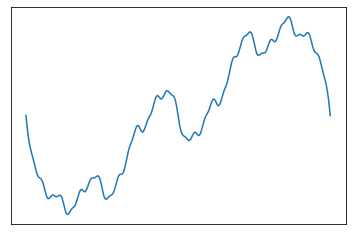

In [9]:
noise_1d = perlin_1d()
plt.plot(noise_1d)
plt.grid()
#seting the figure size for matplotlib
plt.rcParams['figure.figsize'] = [10, 5]
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.show()

## Perlin noise in 2D

A common mistake that people make is to get a random gradient in the interval $[-1, 1]$. This is not correct because the gradient directions would not be random. This could be easily shown by generating such values and plotting the corresponding angles in a histogram.


In [10]:
arr = np.random.random(1000000)
arr = np.rad2deg(np.arccos(arr * 2 - 1))

plt.hist(arr,bins=20,)
plt.xlabel("angle, degrees")
plt.ylabel("# values")
plt.grid()
plt.show()

In order to correctly generate random vectors we take an angle $ \varphi \in [0:2\pi]$ and determine the $x$ and $y$ components.

$$
\mathit{grad}_x = \cos{\varphi}\\
\mathit{grad}_y = \sin{\varphi}
$$

Now we can write functions for the gradient and the dot product

In [11]:
def getGradient2D(lx, ly):
    """
    lx, ly - coordinates of a lattice point
    returns the gradient vectors in [1:-1]
    """
    angle = perm[(lx + perm[ly % 256]) % 256] / 255 * 2 * np.pi
    return np.cos(angle), np.sin(angle)


def dotGradient2d(lx, ly, x, y):
    """
    lx, ly - coordinates of the latice point
    x, y - coordinates of the point
    returns the dot product of the ofset vector and the gradient vectorThe
    """
    grad_x, grad_y = getGradient2D(lx, ly)

    dx = lx - x
    dy = ly - y

    return (dx * grad_x + dy * grad_y)

The function that returns the value of the Perlin noise would look like

In [12]:
def perlin_2d_value(x, y):
    """
    x,y - coordinates of a point
    returns the value of the Perlin noise
    """
    # find the lattice points
    x_p = int(x // 1)
    x_n = x_p + 1
    y_p = int(y // 1)
    y_n = y_p + 1

    # calculate the fadefunction
    sx = x - x_p
    sy = y - y_p

    fade_x = fade(sx)
    fade_y = fade(sy)

    # find the dot products and interpolate along x
    n0 = dotGradient2d(x_p, y_p, x, y)
    n1 = dotGradient2d(x_n, y_p, x, y)
    ix0 = lerp(n0, n1, fade_x)

    n0 = dotGradient2d(x_p, y_n, x, y)
    n1 = dotGradient2d(x_n, y_n, x, y)
    ix1 = lerp(n0, n1, fade_x)

    # interpolate along y and return
    return lerp(ix0, ix1, fade_y)

Now we can use `perlin_2d_value` to find what a Perlin noise would look like. Note that the function accepts argument `norm` which makes the function return the gradient in the interval $[-1,1]$


In [13]:
def perlin_2d(lmin=0, lmax=10, values=1000, octaves=6, norm=True):
    """
    lmin, lmax - interval in for the function
    values - number of values 
    octaves - the number of octaves
    norm - if the function shoud be normalised to be in the interval [-1,1]
    
    returns a list of lists with size values with the values of the Perlin noise
    """
    interval = np.linspace(lmin, lmax, values)
    perlin_matrix = np.zeros((values, values))

    for o in range(0, octaves):
        perlin_o = []

        fr = 2**(o)
        amp = 2**(octaves - o - 1)
        #         print(fr, amp)

        for x in interval:
            sub_list = []
            for y in interval:
                sub_list.append(perlin_2d_value(x * fr, y * fr) * amp)
            perlin_o.append(sub_list)
        perlin_matrix = np.add(perlin_matrix, perlin_o)

    if norm:
        perlin_matrix = perlin_matrix / (2**(octaves + 1) - 1)

    return perlin_matrix

In order to visualize the result for $6$ octaves we do the following

**Note:The next cell takes a lot of time to run**

In [14]:
perlin_matrix_2d = perlin_2d()

In [15]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.matshow(perlin_matrix_2d, cmap='gray')
plt.axis('off')
plt.show()

The data could be used(visualized) as a terrain. This can be done in many [different ways](https://matplotlib.org/3.5.0/tutorials/colors/colormapnorms.html).

In [16]:
fig, ax = plt.subplots()

bounds = np.linspace(-0.2, 0.2, 10)
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256)
pcm = ax.matshow(perlin_matrix_2d, cmap='terrain', norm=norm)

# cb = fig.colorbar(pcm)
plt.axis('off')
plt.show()

## Perlin noise in 3D

For the calculation of Perlin noise in 3D we will use 4 octaves instead of 6 in order to reduce calculation time.
For the calculation in 3D some adjustments have to be made to the `getGradient` and `dotGradient` functions.

In order to generate a random unit vector in 3D space we have to generate $2$ angles $\in [0,2\pi]$.

| ![Spherical_cor.png](perlin_noise_data/img/3D_Spherical.png "source: Wikipedia") |
|:--:|
| *source: Wikipedia.* |

It can be seen in the picture that the components of the gradient unit vector are the following:

$$
\mathit{grad}_x = \sin{\theta}\cos{\varphi}\\
\mathit{grad}_y = \sin{\theta}\sin{\varphi}\\
\mathit{grad}_z = \cos{\theta}
$$


In [17]:
def getGradient3D(lx, ly, lz):
    """
    lx, ly, lz - coordinates of a lattice point
    returns the gradient vectors in [1:-1]
    """
    theta = perm[(perm[(perm[lx % 256] + ly) % 256] + lz) % 256] / 255 * 2 * np.pi
    phi = perm[(perm[(perm[lz % 256] + ly) % 256] + lx) % 256] / 255 * 2 * np.pi
    grad_z = np.sin(theta)

    return np.cos(phi) * np.sin(theta), np.sin(phi) * np.sin(theta), np.cos(
        theta)

The `dotGradient` function remains mostly the same

In [18]:
def dotGradient3D(lx, ly, lz, x, y, z):
    """
    lx, ly, lz- coordinates of the latice point
    x, y, z - coordinates of the point
    returns the dot product of the ofset vector and the gradient vectorThe
    """
    grad_x, grad_y, grad_z = getGradient3D(lx, ly, lz)

    dx = lx - x
    dy = ly - y
    dz = lz - z

    return (dx * grad_x + dy * grad_y + dz * grad_z)

The `perlin_value` for 3D would look like this.

In [19]:
def perlin_3d_value(x, y, z):
    """
    x,y,z - coordinates of a point
    returns the value of the Perlin noise
    """
    # find the lattice points
    x_p = int(x // 1)
    x_n = x_p + 1
    y_p = int(y // 1)
    y_n = y_p + 1
    z_p = int(z // 1)
    z_n = z_p + 1

    # calculate the fadefunction
    sx = x - x_p
    sy = y - y_p
    sz = z - z_p

    fade_x = fade(sx)
    fade_y = fade(sy)
    fade_z = fade(sz)

    # find the dot products and interpolate along x
    #z_p,y_p
    n0 = dotGradient3D(x_p, y_p, z_p, x, y, z)
    n1 = dotGradient3D(x_n, y_p, z_p, x, y, z)
    ix0 = lerp(n0, n1, fade_x)

    #z_p,y_n
    n0 = dotGradient3D(x_p, y_n, z_p, x, y, z)
    n1 = dotGradient3D(x_n, y_n, z_p, x, y, z)
    ix1 = lerp(n0, n1, fade_x)

    #z_n,y_p
    n0 = dotGradient3D(x_p, y_p, z_n, x, y, z)
    n1 = dotGradient3D(x_n, y_p, z_n, x, y, z)
    ix2 = lerp(n0, n1, fade_x)

    #z_n,y_n
    n0 = dotGradient3D(x_p, y_n, z_n, x, y, z)
    n1 = dotGradient3D(x_n, y_n, z_n, x, y, z)
    ix3 = lerp(n0, n1, fade_x)

    #interpolate along y
    iy0 = lerp(ix0, ix1, fade_y)
    iy1 = lerp(ix2, ix3, fade_y)

    # finaly we interpolate along z and return the result
    return lerp(iy0, iy1, fade_z)

And we can use `perlin_3d_value` to find what a Perlin noise would look line

In [20]:
def perlin_3d(lmin=0, lmax=10, values=100, octaves=4, norm=True):
    """
    lmin, lmax - interval in for the function
    values - number of values 
    octaves - the number of octaves
    norm - if the function shoud be normalised to be in the interval [-1,1]
    
    returns a 3D list with the values of the Perlin noise
    """
    interval = np.linspace(lmin, lmax, values)
    perlin_matrix = np.zeros((values, values, values))

    for o in range(0, octaves):
        perlin_o = []

        fr = 2**(o)
        amp = 2**(octaves - o - 1)
        # print(fr, amp)

        for z in interval:
            y_list = []
            for y in interval:
                x_list = []
                for x in interval:
                    x_list.append(
                        perlin_3d_value(x * fr, y * fr, z * fr) * amp)
                y_list.append(x_list)
            perlin_o.append(y_list)

        perlin_matrix = np.add(perlin_matrix, perlin_o)

    if norm:
        perlin_matrix = perlin_matrix / (2**(octaves + 1) - 1)

    return perlin_matrix

**Note:The next cell takes a *lot of time* to run**

In [21]:
perlin3d = perlin_3d()

To visualize the result we could plot it varying the $z$ axis

In [22]:
fig, ax = plt.subplots(2, 3)

ax[0, 0].matshow(perlin3d[0, :, :], cmap='gray')
ax[0, 0].set_title('Z = 0')
ax[0, 0].axis('off')

ax[0, 1].matshow(perlin3d[20, :, :], cmap='gray')
ax[0, 1].set_title('Z = 20')
ax[0, 1].axis('off')

ax[0, 2].matshow(perlin3d[40, :, :], cmap='gray')
ax[0, 2].set_title('Z = 40')
ax[0, 2].axis('off')

ax[1, 0].matshow(perlin3d[60, :, :], cmap='gray')
ax[1, 0].set_title('Z = 60')
ax[1, 0].axis('off')

ax[1, 1].matshow(perlin3d[80, :, :], cmap='gray')
ax[1, 1].set_title('Z = 80')
ax[1, 1].axis('off')

ax[1, 2].matshow(perlin3d[99, :, :], cmap='gray')
ax[1, 2].set_title('Z = 99')
ax[1, 2].axis('off')

plt.show()

In order to reduce the time for calculation, Ken Perlin’s recommended set of gradients for each of the $12$ edges of a cube.


$$
(1,1,0),(-1,1,0),(1,-1,0),(-1,-1,0),\\
(1,0,1),(-1,0,1),(1,0,-1),(-1,0,-1),\\
(0,1,1),(0,-1,1),(0,1,-1),(0,-1,-1)
$$

This is done, because we are dealing with unit vectors the dot product can be calculated using only addition and subtraction.

In [23]:
def dotGradient3d_fast(perm, x, y, z):
    """
    perm - permutation value
    x,y,z, - coordinates of a point
    return  - returns the dot product 
    """

    norm_perm = ((perm / 255) * 11) // 1
    # match case is available in python 10 :/. So this is used instead

    # 0 1 2 3 4 5 6 7 8 9 10 11
    if norm_perm < 6:
        # 0 1 2 3 4 5
        if norm_perm < 3:
            # 0 1 2
            if norm_perm < 1:
                # 0
                return -x + y
            if norm_perm == 1:
                # 1
                return -x + y
            # 2
            return x - y
        if norm_perm < 4:
            # 3
            return -x - y
        if norm_perm == 4:
            # 4
            return x + z
        # 5
        return -x + z
    else:
        # 6 7 8 9 10 11
        if norm_perm < 9:
            # 6 7 8
            if norm_perm < 7:
                # 6
                return x - z
            if norm_perm == 7:
                # 7
                return -x - z
            # 8
            return y + z

        if norm_perm < 10:
            # 9
            return -y + z
        if norm_perm == 10:
            # 10
            return y - z
        # 11
        return -y - z


# if python 10 is used the folowing lines could be uncommented

#     match norm_perm:
#         case  0: return  x + y
#         case  1: return -x + y
#         case  2: return  x - y
#         case  3: return -x - y
#         case  4: return  x + z
#         case  5: return -x + z
#         case  6: return  x - z
#         case  7: return -x - z
#         case  8: return  y + z
#         case  9: return -y + z
#         case 10: return  y - z
#         case 11: return -y - z

Here the `perm` argument is the permutation value of the vector.
Since the values in the original permutation table $\in [0:255]$ we introduce `norm_perm` which returns a corresponding *integer* $\in [0:11]$

To get the `perm` value we simply use the following function

In [24]:
def getHash (lx,ly,lz):
    """
    lx,ly,ly -latice coordinates
    returns a permutation value
    """
    return perm[(perm[(perm[lx%256] + ly)%256] + lz)%256] 

Similarly we can build a function that returns the value in a given point

In [25]:
def perlin_3d_value_fast(x, y, z):
    """
    x,y,z - coordinates of a point
    returns the value of the Perlin noise
    """
    # find the lattice points
    x_p = int(x // 1)
    x_n = x_p + 1
    y_p = int(y // 1)
    y_n = y_p + 1
    z_p = int(z // 1)
    z_n = z_p + 1

    # calculate the fadefunction
    sx = x - x_p
    sy = y - y_p
    sz = z - z_p

    fade_x = fade(sx)
    fade_y = fade(sy)
    fade_z = fade(sz)

    # find the dot products and interpolate along x
    #z_p,y_p
    n0 = dotGradient3d_fast(getHash(x_p, y_p, z_p), sx    , sy, sz)
    n1 = dotGradient3d_fast(getHash(x_n, y_p, z_p), sx - 1, sy, sz)
    ix0 = lerp(n0, n1, fade_x)

    #z_p,y_n
    n0 = dotGradient3d_fast(getHash(x_p, y_n, z_p), sx    , sy - 1, sz)
    n1 = dotGradient3d_fast(getHash(x_n, y_n, z_p), sx - 1, sy - 1, sz)
    ix1 = lerp(n0, n1, fade_x)

    #z_n,y_p
    n0 = dotGradient3d_fast(getHash(x_p, y_p, z_n), sx    , sy, sz - 1)
    n1 = dotGradient3d_fast(getHash(x_n, y_p, z_n), sx - 1, sy, sz - 1)
    ix2 = lerp(n0, n1, fade_x)

    #z_n,y_n
    n0 = dotGradient3d_fast(getHash(x_p, y_n, z_n), sx    , sy - 1, sz - 1)
    n1 = dotGradient3d_fast(getHash(x_n, y_n, z_n), sx - 1, sy - 1, sz - 1)
    ix3 = lerp(n0, n1, fade_x)

    #interpolate along y
    iy0 = lerp(ix0, ix1, fade_y)
    iy1 = lerp(ix2, ix3, fade_y)

    # finaly we interpolate along z and return the result
    result = lerp(iy0, iy1, fade_z)
    # if result > 1 or result < 0:
    #     print (x,y,z)
    return result
    # return lerp(iy0,iy1,fade_z)

We can add a parameter in the function `perlin_3d` in order to choose by which algorithm the values should be calculated.
This could be easily done with one if statement in the most inner loop

```python
if fast:
    x_list.append(
    perlin_3d_value_fast(x * fr, y * fr, z * fr) * amp)
else:
    x_list.append(
    perlin_3d_value(x * fr, y * fr, z * fr) * amp)
```

In [26]:
def perlin_3d(lmin=0, lmax=10, values=100, octaves=4, norm=True, fast=False):
    """
    lmin, lmax - interval in for the function
    values - number of values 
    octaves - the number of octaves
    norm - if the function shoud be normalised to be in the interval [-1,1]
    
    returns a 3D list with the values of the Perlin noise
    """
    interval = np.linspace(lmin, lmax, values)
    perlin_matrix = np.zeros((values, values, values))

    for o in range(0, octaves):
        perlin_o = []

        fr = 2**(o)
        amp = 2**(octaves - o - 1)
        # print(fr, amp)

        for z in interval:
            y_list = []
            for y in interval:
                x_list = []
                for x in interval:
                    if fast:
                        x_list.append(
                            perlin_3d_value_fast(x * fr, y * fr, z * fr) * amp)
                    else:
                        x_list.append(
                            perlin_3d_value(x * fr, y * fr, z * fr) * amp)
                y_list.append(x_list)
            perlin_o.append(y_list)

        perlin_matrix = np.add(perlin_matrix, perlin_o)

    if norm:
        perlin_matrix = perlin_matrix / (2**(octaves + 1) - 1)

    return perlin_matrix

**Note:The next cell takes a lot of time to run**

In [27]:
perlin3d_fast = perlin_3d(fast=True)

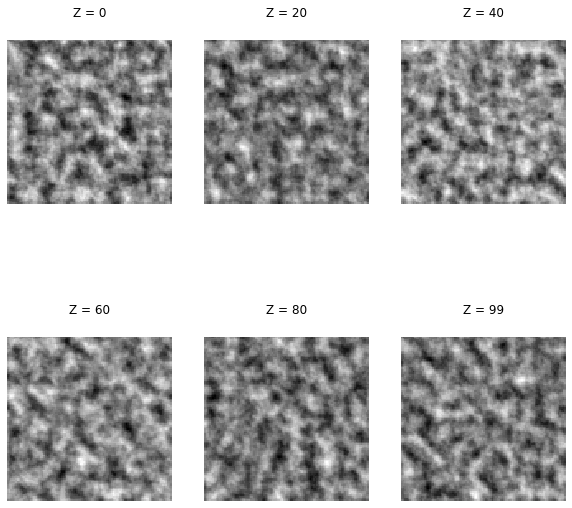

In [28]:
fig, ax = plt.subplots(2, 3)

ax[0, 0].matshow(perlin3d_fast[0, :, :], cmap='gray')
ax[0, 0].set_title('Z = 0')
ax[0, 0].axis('off')

ax[0, 1].matshow(perlin3d_fast[20, :, :], cmap='gray')
ax[0, 1].set_title('Z = 20')
ax[0, 1].axis('off')

ax[0, 2].matshow(perlin3d_fast[40, :, :], cmap='gray')
ax[0, 2].set_title('Z = 40')
ax[0, 2].axis('off')

ax[1, 0].matshow(perlin3d_fast[60, :, :], cmap='gray')
ax[1, 0].set_title('Z = 60')
ax[1, 0].axis('off')

ax[1, 1].matshow(perlin3d_fast[80, :, :], cmap='gray')
ax[1, 1].set_title('Z = 80')
ax[1, 1].axis('off')

ax[1, 2].matshow(perlin3d_fast[99, :, :], cmap='gray')
ax[1, 2].set_title('Z = 99')
ax[1, 2].axis('off')

plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

Finally we can compare the two algorithms side by side to see if there are any noticeable differences.

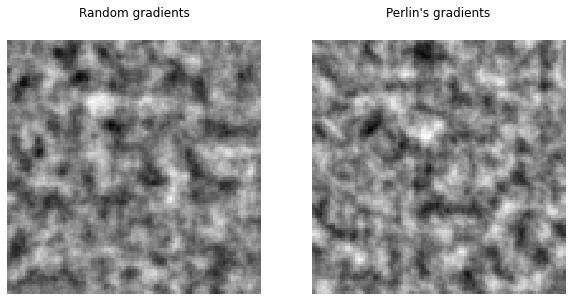

In [29]:
fig, ax = plt.subplots(1, 2)
ax[0].matshow(perlin3d[50,:,:], cmap = 'gray')
ax[0].set_title('Random gradients')
ax[0].axis('off')

ax[1].matshow(perlin3d_fast[50,:,:], cmap = 'gray')
ax[1].set_title('Perlin\'s gradients')
ax[1].axis('off')

plt.show()

As you can see the results from both of the algorithms are similar and could be used for their purposes

#  Resources

During the writhing of this notebook I have used many resources and here are some of the best:

* [Wikipedia](https://en.wikipedia.org/wiki/Perlin_noise)
* [Scratchapixel 2.0](https://www.scratchapixel.com/lessons/procedural-generation-virtual-worlds/perlin-noise-part-2/perlin-noise-computing-derivatives)
* [Gpfault](https://gpfault.net/posts/perlin-noise.txt.html)
* [Simplex noise demystified by Stefan Gustavson](https://weber.itn.liu.se/~stegu/simplexnoise/simplexnoise.pdf)
* [Adrian's soapbox](http://adrianb.io/2014/08/09/perlinnoise.html)
* [James Fisher's blog](https://jameshfisher.com/2017/10/15/1d-perlin-noise/)